# Generate the Input Data

In [5]:
import numpy as np

class Precursor:
    def __init__(self, decay_constant, beta):
        self.decay_constant = decay_constant
        self.beta = beta

precursors = [Precursor(0.0, 0.0)]
beta_sum = sum([p.beta for p in precursors])

t_end = 6
t_step = 1000 # number of time steps
t = np.linspace(0,t_end,t_end*t_step+1)

up = .5 # $/s (upwards reactivity ramp)
down = .1 # $/s (downwards reactivity ramp)
t1 = 1
t1_i = round(t1*t_step) # index of t1
rho_imp = np.zeros(len(t))
rho_imp[:(t1_i+1)] = up*t[:(t1_i+1)]
rho_imp[(t1_i+1):] = up*t1 - down*(t[(t1_i+1):] - t1)

beta_eff = beta_sum * np.ones(len(t))
rho_imp = rho_imp
gen_time = 2.6e-15 * np.ones(len(t))
lambduh_h = np.ones(len(t))
pow_norm = np.ones(len(t))

# Plot the Input Reactivity

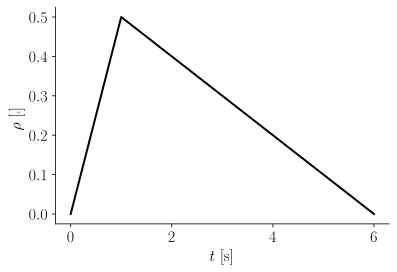

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')


mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
mpl.rcParams.update({'font.size': 16})
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

ax = plt.subplot(111)
ax.plot(t, rho_imp, linewidth=2, color='k', label="imposed reactivity")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('$t$ [s]')
plt.ylabel(r'$\rho$ [\$]')
plt.savefig('rho_ramp_comparison.pgf',bbox_inches='tight',transparent=True)
plt.show()

# Write Input Data to XML File

In [7]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

theta = 0.5

epke_input = ET.Element("epke_input", theta=str(theta), gamma_d="0.0", 
                        initial_power="1.0", eta="1.0")
precursors_element = ET.SubElement(epke_input, "precursors")
ET.SubElement(precursors_element, "precursor", 
              decay_constant=str(precursors[0].decay_constant), 
              beta=str(precursors[0].beta))
ET.SubElement(epke_input, "time").text = ' '.join(map(str, t))
ET.SubElement(epke_input, "gen_time").text = ' '.join(map(str, gen_time))  
ET.SubElement(epke_input, "pow_norm").text = ' '.join(map(str, pow_norm))
ET.SubElement(epke_input, "rho_imp").text = ' '.join(map(str, rho_imp))
ET.SubElement(epke_input, "beta_eff").text = ' '.join(map(str, beta_eff))
ET.SubElement(epke_input, "lambda_h").text = ' '.join(map(str, lambduh_h))

# pretty print and write to xml
xmlstr = minidom.parseString(ET.tostring(epke_input)).toprettyxml(indent="   ")
with open("epke_input.xml", "w") as f:
    f.write(xmlstr)

# Run the EPKE Executable

In [8]:
import subprocess

args = "./epke-run examples/epke_input.xml".split()
popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
popen.wait()
while True:
    line = popen.stdout.readline()
    if not line:
        break
    print(line.rstrip().decode('utf-8'))

Reading input file: examples/epke_input.xml
solving...
completed solve
writing output to examples/epke_output.xml


# Read the XML Output

In [9]:
tree = ET.parse('epke_output.xml')
root = tree.getroot()

for child in root:
    if (child.tag == 'time'):
        time_out = np.fromstring(child.attrib['values'], dtype=float, sep=',')
    if (child.tag == 'power'):
        p_out = np.fromstring(child.attrib['values'], dtype=float, sep=',')

# Plot the Results

In [16]:
def analytic_soln(lambduh, t, t1, t_step, up, down, p0):
    t1_i = round(t1*t_step)
    p0_soln = p0
    p_soln = np.zeros(len(t))
    p_soln[:(t1_i+1)] = p0_soln*np.exp(-lambduh*t[:(t1_i+1)])*\
                        (1/(1 - up*t[:(t1_i+1)]))**(lambduh/up + 1)
    p_soln[(t1_i+1):] = p_soln[t1_i]*np.exp(-lambduh*(t[(t1_i+1):] - t1))*((1 - up*t1)/\
                        (1 - up*t1 + down*(t[(t1_i+1):] - t1)))**(-lambduh/down + 1)
    return p_soln

precursors = [Precursor(0.0, 0.0)]

lambduh_list = np.asarray([p.decay_constant for p in precursors])
p_soln = analytic_soln(lambduh_list, t, t1, t_step, up, down, 1.0)

precursors = [Precursor(0.49405, 0.0076)]

lambduh_list_delayed = np.asarray([p.decay_constant for p in precursors])
p_soln_delayed = analytic_soln(lambduh_list_delayed, t, t1, t_step, up, down, 1.0)

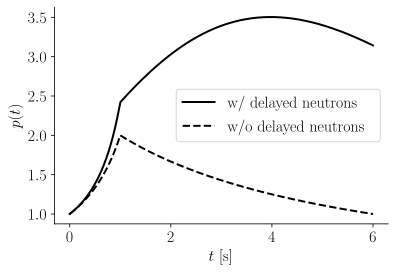

In [32]:
plt.rc('text', usetex=True)
ax = plt.subplot(111)
ax.plot(t, p_soln_delayed, color='k', linewidth=2, label='w/ delayed neutrons')
ax.plot(t, p_soln, linestyle='--', color='k', linewidth=2, label='w/o delayed neutrons')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('$t$ [s]')
plt.ylabel('$p(t)$')
plt.legend()
plt.savefig('power_ramp_comparison.pgf',bbox_inches='tight',transparent=True)
plt.show()